# S&P 500 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'GSPC'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='1y', interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-04-01 00:00:00-04:00,5257.970215,5263.950195,5229.200195,5243.770020,3325930000,0.0,0.0
2024-04-02 00:00:00-04:00,5204.290039,5208.339844,5184.049805,5205.810059,3886590000,0.0,0.0
2024-04-03 00:00:00-04:00,5194.370117,5228.750000,5194.370117,5211.490234,3703250000,0.0,0.0
2024-04-04 00:00:00-04:00,5244.049805,5256.589844,5146.060059,5147.209961,4075680000,0.0,0.0
2024-04-05 00:00:00-04:00,5158.950195,5222.180176,5157.209961,5204.339844,3386780000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-24 00:00:00-04:00,5718.080078,5775.140137,5718.080078,5767.569824,4517990000,0.0,0.0
2025-03-25 00:00:00-04:00,5775.959961,5786.950195,5760.419922,5776.649902,4467340000,0.0,0.0
2025-03-26 00:00:00-04:00,5771.660156,5783.620117,5694.410156,5712.200195,4183140000,0.0,0.0


In [3]:
df0 = ticker.history(period='3y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-29 00:00:00-04:00,4602.859863,4637.299805,4589.660156,4631.600098,5085910000,0.0,0.0
2022-03-30 00:00:00-04:00,4624.200195,4627.770020,4581.319824,4602.450195,4385570000,0.0,0.0
2022-03-31 00:00:00-04:00,4599.020020,4603.069824,4530.410156,4530.410156,4823020000,0.0,0.0
2022-04-01 00:00:00-04:00,4540.319824,4548.700195,4507.569824,4545.859863,4562940000,0.0,0.0
2022-04-04 00:00:00-04:00,4547.970215,4583.500000,4539.209961,4582.640137,4547350000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-24 00:00:00-04:00,5718.080078,5775.140137,5718.080078,5767.569824,4517990000,0.0,0.0
2025-03-25 00:00:00-04:00,5775.959961,5786.950195,5760.419922,5776.649902,4467340000,0.0,0.0
2025-03-26 00:00:00-04:00,5771.660156,5783.620117,5694.410156,5712.200195,4183140000,0.0,0.0


## Moving Median

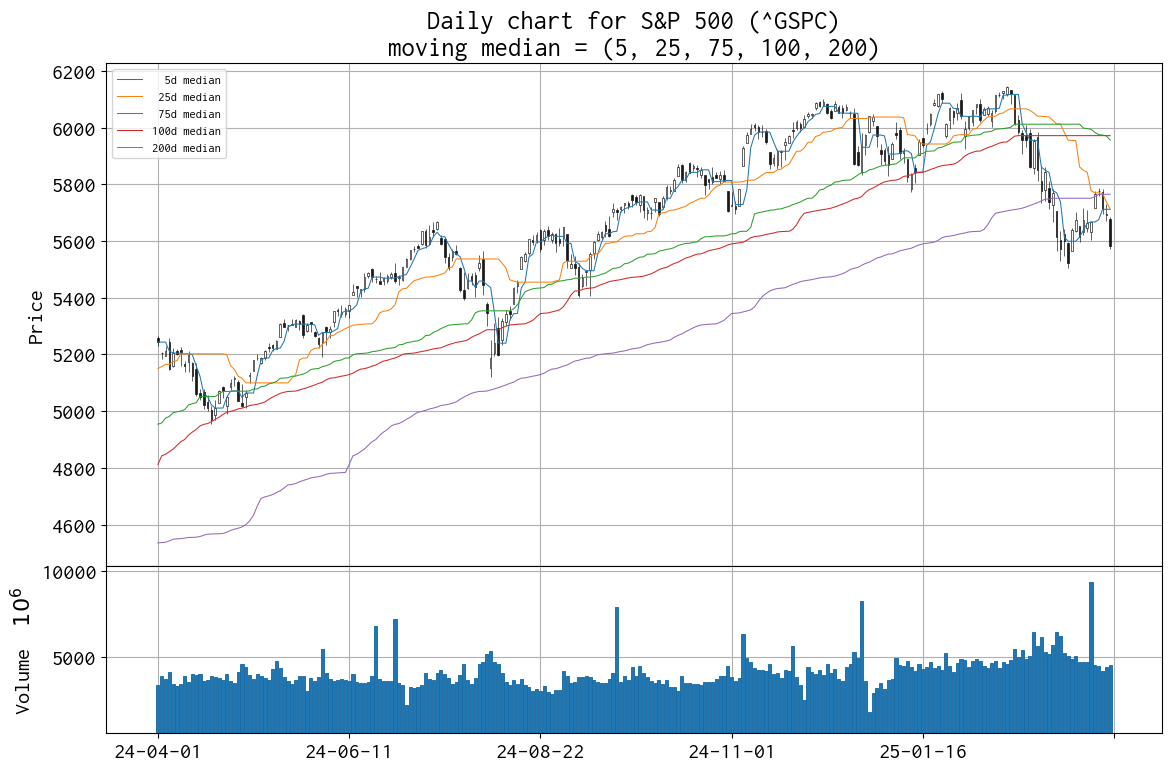

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax[0]),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax[0]),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax[0]),
]   

mpf.plot(
    df, type='candle', style='default',
    volume=ax[1],
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)
ax[0].set_title('Daily chart for %s (%s)\nmoving median = (5, 25, 75, 100, 200)' %(ticker.info['longName'], symbol))
ax[0].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-27 00:00:00-04:00,5695.640137,5732.279785,5670.939941,5693.310059,4403460000,0.0,0.0
2025-03-28 00:00:00-04:00,5679.200195,5685.890137,5572.419922,5580.939941,4513330000,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-03-27 00:00:00-04:00    5693.310059
2025-03-28 00:00:00-04:00    5580.939941
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-03-27 00:00:00-04:00           NaN
2025-03-28 00:00:00-04:00   -112.370117
Name: Close, dtype: float64

In [8]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-28 00:00:00-04:00   -98.260254
dtype: float64

In [9]:
df['Close'].rolling(9).median().tail()

Date
2025-03-24 00:00:00-04:00    5662.890137
2025-03-25 00:00:00-04:00    5667.560059
2025-03-26 00:00:00-04:00    5675.120117
2025-03-27 00:00:00-04:00    5675.290039
2025-03-28 00:00:00-04:00    5675.290039
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail()

Date
2025-03-24 00:00:00-04:00    5662.890137
2025-03-25 00:00:00-04:00    5662.890137
2025-03-26 00:00:00-04:00    5662.890137
2025-03-27 00:00:00-04:00    5667.560059
2025-03-28 00:00:00-04:00    5667.560059
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail()

Date
2025-03-24 00:00:00-04:00    5774.175049
2025-03-25 00:00:00-04:00    5773.425049
2025-03-26 00:00:00-04:00    5768.885010
2025-03-27 00:00:00-04:00    5753.044922
2025-03-28 00:00:00-04:00    5725.360107
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail()

Date
2025-03-24 00:00:00-04:00    5955.655029
2025-03-25 00:00:00-04:00    5955.655029
2025-03-26 00:00:00-04:00    5955.655029
2025-03-27 00:00:00-04:00    5955.655029
2025-03-28 00:00:00-04:00    5955.655029
Name: Close, dtype: float64

## Robust Bollinger's bands

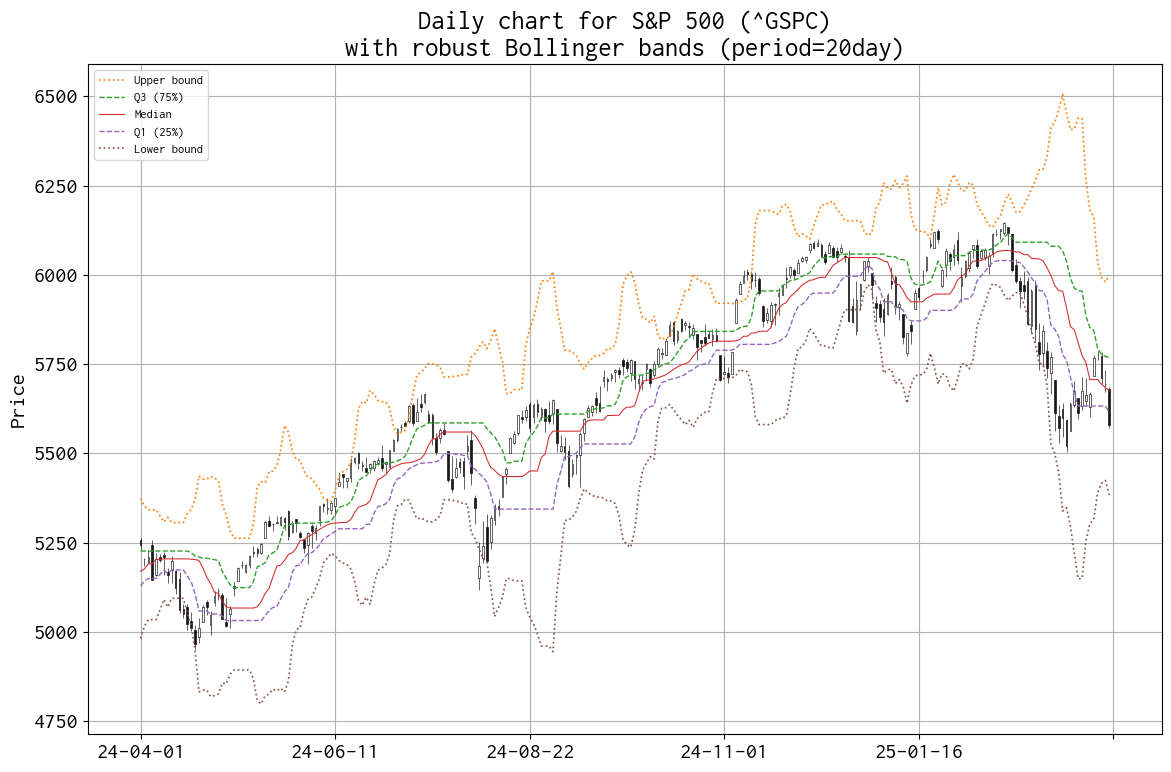

In [13]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%dday)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%dday)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

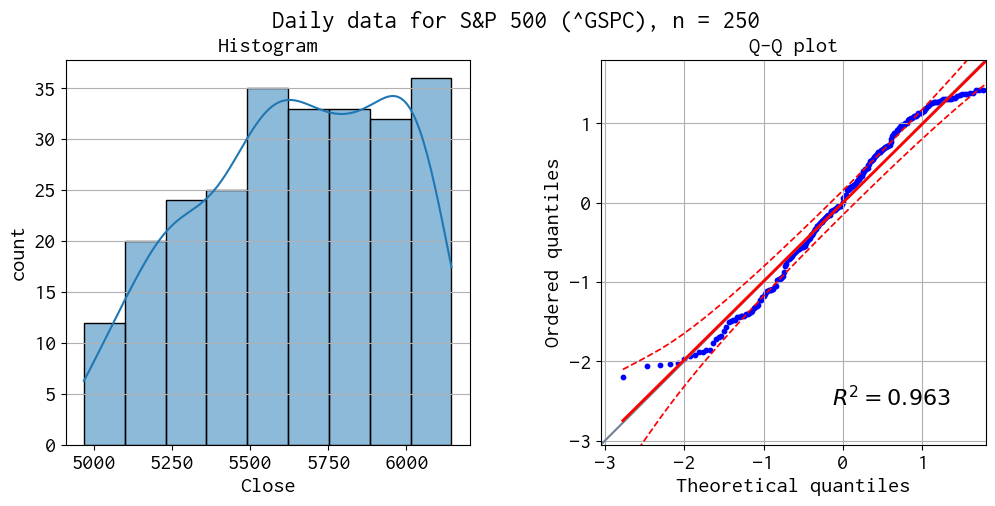

In [14]:
plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_daily_histogram_qqplot_%s.png' % code)
plt.show()